# Customer Churn Prediction in Telco
**IBM Sample Data sets** from: *https://www.kaggle.com/datasets/blastchar/telco-customer-churn*

Aim: 
- Predict behavior to **retain customers** in telephone company `Telco`. You can analyze all relevant customer data and **develop focused customer retention programs**.

The data is provided in the csv file `WA_Fn-UseC_-Telco-Customer-Churn.csv`.

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called `"Churn"`.
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

- EDA

In [2]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2731,1110-KYLGQ,Female,0,No,No,63,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),108.25,6780.1,No
500,4374-YMUSQ,Male,0,No,No,34,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),116.25,3899.05,No
5471,3002-WQZWT,Female,0,No,No,29,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.20,1993.25,No
1744,8952-WCVCD,Female,0,Yes,No,41,Yes,No,Fiber optic,Yes,...,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),104.45,4162.05,No
2337,4612-THJBS,Female,1,No,No,56,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),104.75,5510.65,Yes


In [3]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
df['TotalCharges'].dtype
df['TotalCharges'].value_counts(dropna=False, ascending=True)

TotalCharges
29.85       1
59.55       1
300.7       1
4234.15     1
6496.15     1
           ..
20.05       8
19.9        8
19.75       9
20.2       11
           11
Name: count, Length: 6531, dtype: int64

In [5]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype('float')
df['TotalCharges'].dtype
df['TotalCharges'].value_counts(dropna=False, ascending=True)

TotalCharges
29.85       1
59.55       1
300.70      1
4234.15     1
6496.15     1
           ..
20.05       8
19.90       8
19.75       9
20.20      11
NaN        11
Name: count, Length: 6531, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.describe().select_dtypes(np.number)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
df_no_id = df.drop(columns=['customerID'])

for col in df_no_id.columns:
    print(col, ":",  df[col].unique())

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2

- Data Visualisation

**When** do customers churn?

c:\Users\tseng\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tseng\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


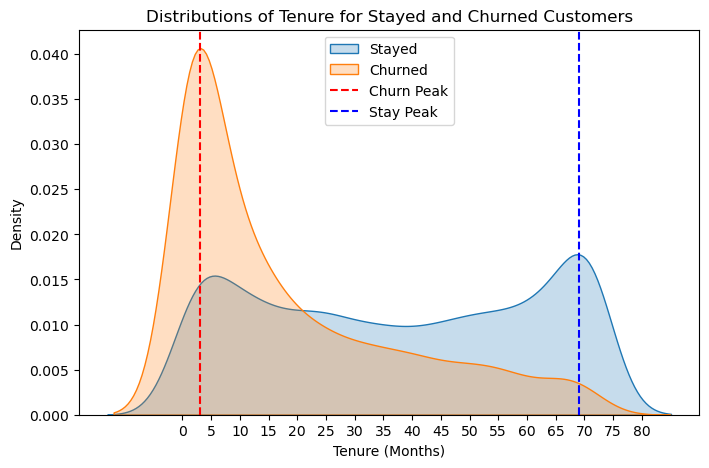

In [9]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['Churn'] == 'No']['tenure'], label='Stayed', fill=True)
sns.kdeplot(df[df['Churn'] == 'Yes']['tenure'], label='Churned', fill=True)
plt.xlabel('Tenure (Months)')
plt.ylabel('Density')

plt.xticks(np.arange(0, df['tenure'].max() + 10, 5))
plt.axvline(x=3, linestyle='--', color='r')
plt.axvline(x=69, linestyle='--', color='b')
plt.title('Distributions of Tenure for Stayed and Churned Customers')
plt.legend(['Stayed', 'Churned', 'Churn Peak', 'Stay Peak'], loc='upper center')
plt.show()

- **Insights**
1. **High Churn Rates** Around the First 5 Months (i.e. **the first half year**):
    
    - May indicate unsatisfactory service, better competitor offers, or poor onboarding

2. Stable Long-Term Customers:

    - A second peak around 60-70 months (i.e. the sixth year) for retained customers suggests **loyal customers tend to stay long-term**.

    - Encouraging long-term contracts may **reduce churn**.

3. Longer Tenure, Lower Churn:

    - Customers with **`tenure`** > around 24 months (i.e. **two years**) start to have a **lower churn rate**.

    - **Retention strategies** should **focus on the first few months**.


Do the **`monthly`** and **`total charges`** affect churn rate?

p-value: 2.1277194691591206e-60, m-value: 70.35


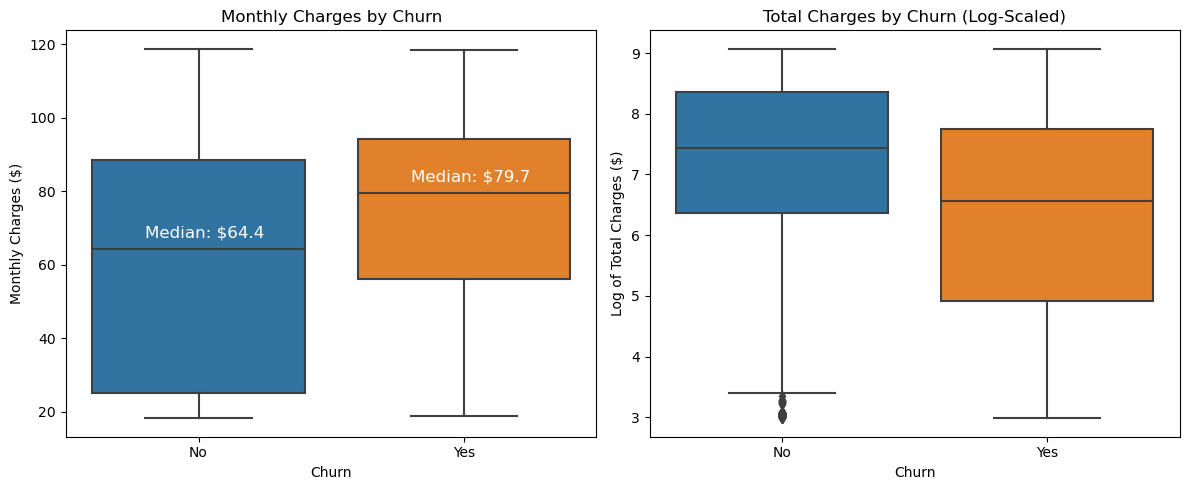

In [10]:
# Mood's Median Test
from scipy.stats import median_test
monthly_no = df[df["Churn"] == "No"]["MonthlyCharges"]
monthly_yes = df[df["Churn"] == "Yes"]["MonthlyCharges"]

s, p_value, m_value, table = median_test(monthly_no, monthly_yes)
print(f"p-value: {p_value}, m-value: {m_value}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Monthly Charges Boxplot
sns.boxplot(x=df["Churn"], y=df["MonthlyCharges"], ax=axes[0])
axes[0].set_title("Monthly Charges by Churn")
axes[0].set_ylabel("Monthly Charges ($)")
axes[0].set_xlabel("Churn")
median_monthly_no = monthly_no.median()
median_monthly_yes = monthly_yes.median()
axes[0].annotate(f"Median: ${median_monthly_no:.1f}", xy=(-0.2, median_monthly_no + 3), color='white', fontsize=12)
axes[0].annotate(f"Median: ${median_monthly_yes:.1f}", xy=(0.8, median_monthly_yes + 3), color='white', fontsize=12)

# Total Charges Boxplot (with log scale)
sns.boxplot(x=df["Churn"], y=np.log1p(df["TotalCharges"]), ax=axes[1])
axes[1].set_title("Total Charges by Churn (Log-Scaled)")
axes[1].set_ylabel("Log of Total Charges ($)")
axes[1].set_xlabel("Churn")

# Show plot
plt.tight_layout()
plt.show()

Our null hypothesis is that the customers who stayed and churned have the same median value for the monthly charges.

Since the p-value < 0.05, we reject the null hypothesis.

- **Insights**
1. **`Churned`** Customers **Pay More Monthly Charges**:
    
    - May indicate poor service quality, pricing, reliability issues

2. **`Churned`** Customers Have a **Lower Total Charge**:

    - May indicate that **newer customers** who haven't accumulated high total charges **tend to churn more**.


Does the **internet service type** affect churn rate?

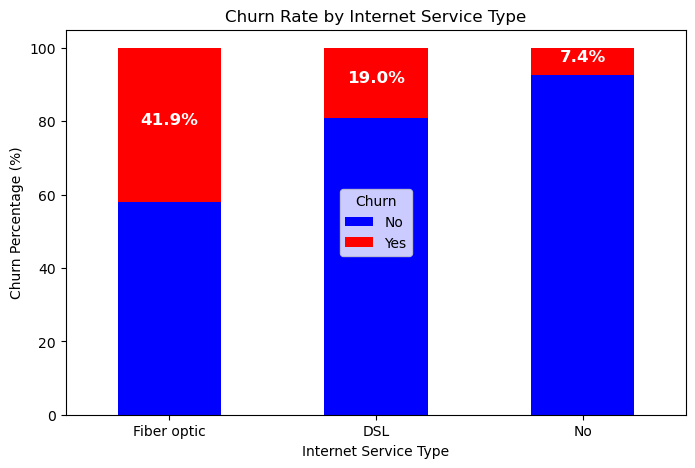

In [11]:
churn_counts = df.groupby("InternetService")["Churn"].value_counts(normalize=True).unstack() * 100

# Sort by churn percentage
churn_counts = churn_counts.sort_values(by='Yes', ascending=False)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
churn_counts.plot(kind="bar", stacked=True, color=["blue", "red"], ax=ax)

# Add annotations 
for i, category in enumerate(churn_counts.index):
    churn_rate = churn_counts.loc[category, "Yes"]
    ax.text(i, churn_counts.loc[category, "No"] + churn_rate / 2, f"{churn_rate:.1f}%", 
            ha="center", color="white", fontsize=12, fontweight="bold")

plt.xlabel("Internet Service Type")
plt.xticks(rotation=0)
plt.ylabel("Churn Percentage (%)")
plt.title("Churn Rate by Internet Service Type")
plt.legend(title="Churn", loc='center')
plt.show()

- **Insights**

1. **`Fiber Optic`** Has the **Highest Churn Rate**:
    
    - May indicate poor service quality, pricing, reliability issues

2. **`DSL`** Customers **Churn Less**:

    - May indicate more stable pricing or customer loyalty. 


Does the **contract type** affect the churn rate?

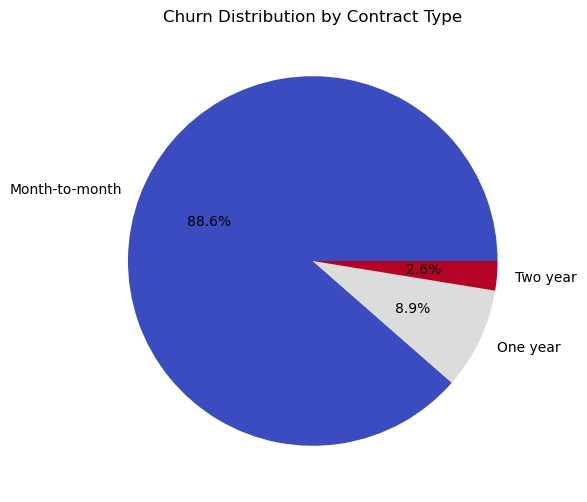

In [12]:
df[df['Churn'] == 'Yes']['Contract'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), colormap='coolwarm')
plt.title("Churn Distribution by Contract Type")
plt.ylabel("")
plt.show()

- **Insights**

**`Month-to-month`** Contracts Have the **Highest Churn Rate**:

As discussed before, we need long-term retention programs to retain customers who potentially churn in the first few months. 

- Data Preprocessing

In [13]:
# Sub-setting numeric feature for standard scaling
X_numeric = df_no_id[['tenure', 'MonthlyCharges' , 'TotalCharges']]

scaler = StandardScaler()
imputer = SimpleImputer()
X_numeric = imputer.fit_transform(X_numeric)
X_numeric_scaled = scaler.fit_transform(X_numeric)
print('X_numeric_scaled_shape:', X_numeric_scaled.shape)

# Converting back into a dataframe
X_numeric_scaled = pd.DataFrame(X_numeric_scaled)
X_numeric_scaled.columns = ['tenure', 'MonthlyCharges' , 'TotalCharges']

# Sub-setting categorical feature for One-Hot Encoding
X_category = df_no_id.drop(columns=['tenure', 'MonthlyCharges' , 'TotalCharges', 'Churn'])

X_category['SeniorCitizen'] = X_category['SeniorCitizen'].map({1: 'Yes', 0: 'No'})
X_category = X_category.astype('category')

X_category_labelled = pd.get_dummies(X_category)
print('X_category_labelled_shape: ', X_category_labelled.shape)

# Isolating the target variable
y = df['Churn'].map({'No': 0, 'Yes': 1})
print('y_final_shape: ', y.shape)

# Concatenating the preprocessed features
X = pd.concat([X_numeric_scaled, X_category_labelled], axis=1)
print('X_final_shape: ', X.shape)

X_numeric_scaled_shape: (7043, 3)
X_category_labelled_shape:  (7043, 43)
y_final_shape:  (7043,)
X_final_shape:  (7043, 46)


- **Feature Selection**: Principal Component Analysis (**PCA**)

(7043, 18)


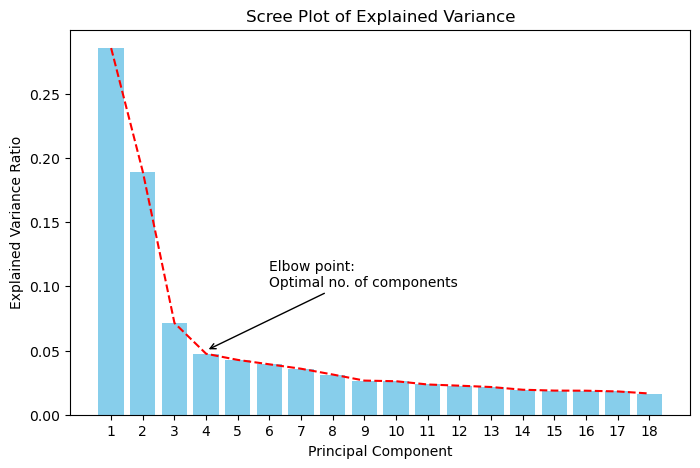

(7043, 18)


In [14]:
# Ensure reproducibility
seed = 50

# Principal component features
pca= PCA(random_state=seed, n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

explained_var = pca.explained_variance_ratio_
components = np.arange(1, len(explained_var) + 1)

# Plot the explained variance for each component
plt.figure(figsize=(8, 5))
plt.bar(components, explained_var, color='skyblue')
plt.plot(components, explained_var, color='red', linestyle='--')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot of Explained Variance")
plt.xticks(components)

plt.annotate(xy=(4, 0.05), xytext=(6, 0.1), text='Elbow point:\nOptimal no. of components', 
             arrowprops={'arrowstyle': '->', 'color': 'black'})
plt.show()

X_pca_95 = pca.fit_transform(X)
print(X_pca_95.shape)

- Baseline Model Testing

F1_score: 0.553
roc_auc_score: 0.825
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1552
           1       0.60      0.52      0.55       561

    accuracy                           0.78      2113
   macro avg       0.71      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113



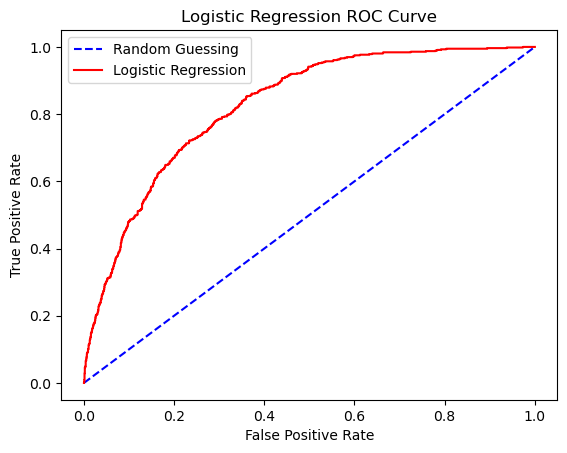

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y, stratify=y, random_state=seed, test_size=0.3)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_probs = logreg.predict_proba(X_test)[:, 1]

f1_logreg = f1_score(y_test, y_pred)
print(f"F1_score: {f1_logreg:.3f}")

roc_auc_logreg = roc_auc_score(y_test, y_pred_probs)
print(f"roc_auc_score: {roc_auc_logreg:.3f}")
print(classification_report(y_test, y_pred))

thresholds = 0.5
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], c='blue', linestyle='--')
plt.plot(fpr, tpr, 'r')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(['Random Guessing', 'Logistic Regression'])
plt.show()

- Advanced Model Training & Hyperparameter Tuning

Best params for XGBClassifier: {'subsample': 0.47368421052631576, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.894736842105263}
classification_report for XGBClassifier:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1552
           1       0.58      0.50      0.54       561

    accuracy                           0.77      2113
   macro avg       0.71      0.68      0.69      2113
weighted avg       0.76      0.77      0.77      2113

F1_score: 0.537
ROC AUC score: 0.815


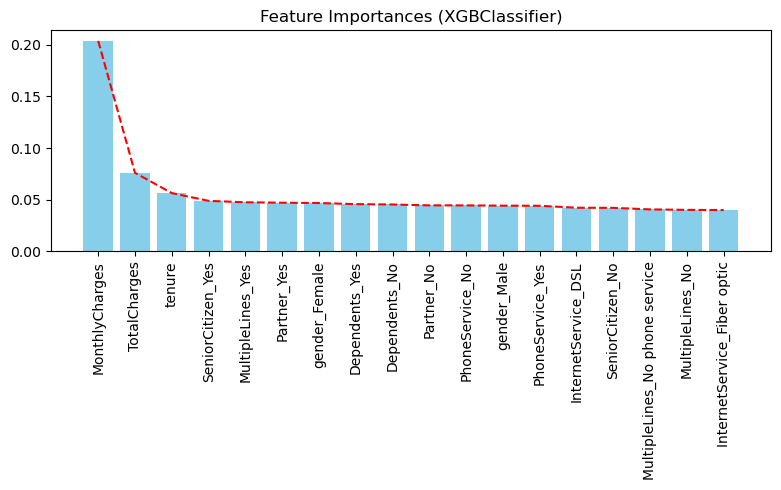

Best params for RandomForestClassifier: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 6}
classification_report for RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.62      0.53      0.57       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113

F1_score: 0.569
ROC AUC score: 0.827


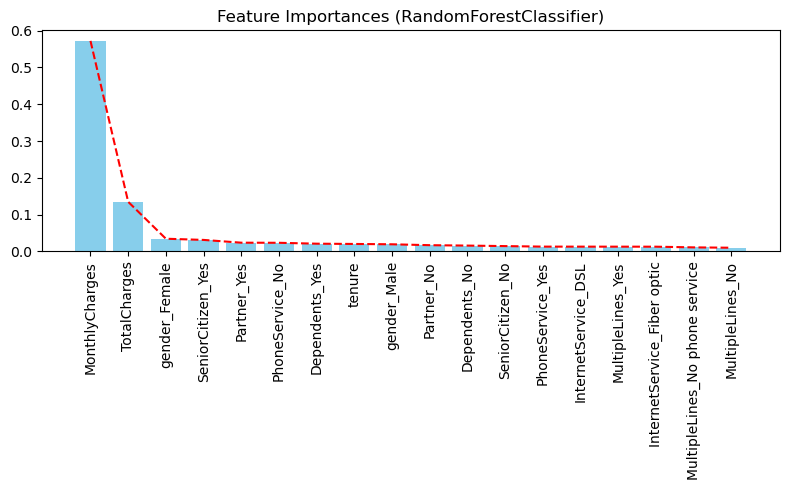

In [ ]:
# Instantiate ensemble models
xgbc = xgb.XGBClassifier(objective='binary:logistic', random_state=seed)
rfc = RandomForestClassifier(random_state=seed)

# Instantiate param grids for different models
xgbc_grid = {
    'n_estimators': np.arange(100, 400, 100),
    'max_depth': np.arange(1, 20),
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': np.linspace(0, 1, 20),
    'colsample_bytree': np.linspace(0, 1, 20)
}

rfc_grid =  {
    'n_estimators': np.arange(100, 500, 100),     # Number of trees in the forest
    'max_depth': np.arange(1, 50, 5),             # Maximum depth of each tree; None means nodes are expanded until all leaves are pure
    'min_samples_split': [2, 5, 10],              # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]        # The number of features to consider when looking for the best split
}

# Instantiate lists for different models and their metrics
model_list = [xgbc, rfc]
model_name_list = []
grid_list = [xgbc_grid, rfc_grid]
f1_list = []
roc_auc_list = []

for model, param_grid in zip(model_list, grid_list):
    random_grid = RandomizedSearchCV(model, param_grid, cv=10, scoring='f1', n_jobs=-1)
    random_grid.fit(X_train, y_train)
    print(f'Best params for {model.__class__.__name__}: {random_grid.best_params_}')
    
    best_model = random_grid.best_estimator_
    best_model.fit(X_train, y_train)
    model_name_list.append(best_model.__class__.__name__)

    # Compute F1-score
    y_pred = best_model.predict(X_test)
    best_f1 = f1_score(y_test, y_pred)
    f1_list.append(best_f1)

    # Compute ROC AUC score
    y_pred_probs = best_model.predict_proba(X_test)[:, 1]
    roc_auc_val = roc_auc_score(y_test, y_pred_probs)
    roc_auc_list.append(roc_auc_val)

    print(f"classification_report for {model.__class__.__name__}:\n {classification_report(y_test, y_pred)}")
    print(f"F1_score: {best_f1:.3f}")
    print(f"ROC AUC score: {roc_auc_val:.3f}")

    # Plot feature importances for each model
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 5))
        plt.title(f"Feature Importances ({best_model.__class__.__name__})")
        plt.bar(range(len(importances)), importances[indices], align="center", color='skyblue')
        plt.plot(range(len(importances)), importances[indices], linestyle='--', color='r')
        plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

In [19]:
# Fit the voting model
voting_classifier = VotingClassifier(estimators=[
    ('xgb', xgbc),
    ('rf', rfc),
    ('logreg', logreg)
], voting='soft', n_jobs=-1)

voting_classifier.fit(X_train, y_train)
y_pred_vote = voting_classifier.predict(X_test)
f1_vote = f1_score(y_test, y_pred_vote)
y_pred_probs_vote = voting_classifier.predict_proba(X_test)[:, 1]
roc_auc_vote = roc_auc_score(y_test, y_pred_probs_vote)

print(f"Voting Classifier F1 Score: {f1_vote:.3f}")
print(f"Voting Classifier ROC AUC Score: {roc_auc_vote:.3f}")

Voting Classifier F1 Score: 0.550
Voting Classifier ROC AUC Score: 0.824


- **Business Insights**

**`MonthlyCharges`** and **`TotalCharges`** are the Top Two Predictors in common, followed by `tenre`, `gender` and `MultipleLines`:

1. Again, prove that the charges paid by the customers affect their `churn` rate.
    
2. Consider re-evaluating pricing plans or offering early discounts to high-risk customers.

- Visualising Model Performances

c:\Users\tseng\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\tseng\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


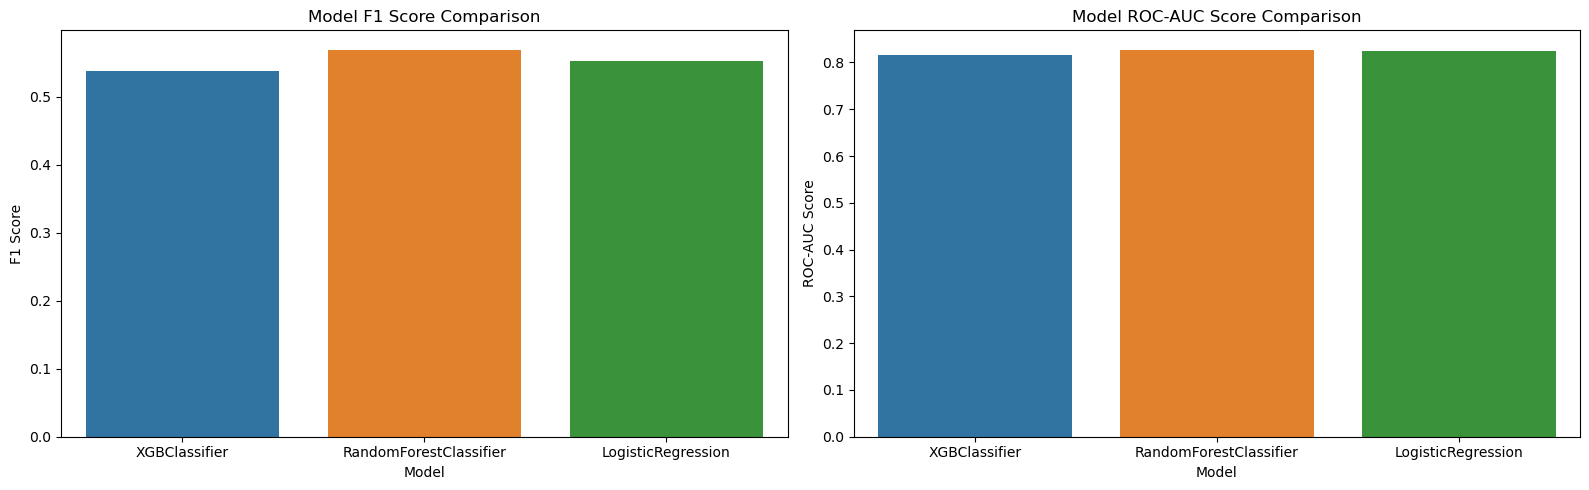

In [18]:
model_name_list.append('LogisticRegression')
f1_list.append(f1_logreg)
roc_auc_list.append(roc_auc_logreg)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot F1 scores 
sns.barplot(ax=axs[0], x=model_name_list, y=f1_list)
axs[0].set_title("Model F1 Score Comparison")
axs[0].set_xlabel("Model")
axs[0].set_ylabel("F1 Score")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)

# Plot ROC-AUC scores 
sns.barplot(ax=axs[1], x=model_name_list, y=roc_auc_list)
axs[1].set_title("Model ROC-AUC Score Comparison")
axs[1].set_xlabel("Model")
axs[1].set_ylabel("ROC-AUC Score")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()